In [4]:
import scipy.io
data = scipy.io.loadmat('../../data/url.mat')

**create list for labels and data, where one entry is the data for the day with this index**

In [5]:
import numpy as np

num_of_days = 120
X, Y = [], []

for i in range(num_of_days):
    day_data = data["Day" + str(i)]
    X.append(day_data[0][0][0])
    Y.append(day_data[0][0][1])

**flatten y to not be a nested array**

In [6]:
# y-data are lists of numpy-arrays

for i in range(len(Y)):
    Y[i] = [element for sublist in Y[i] for element in sublist]
   
# y-data becomes a list of lists

In [7]:
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
import numpy as np

# takes a range of days (start until to)
# fits the model with the data from the range until "to" itself
# for day "to" for each url_batch the data is refitted (prevoius days data from range + all batches up to current)
# and predicticed for the succesive batch of urls
# returns the cumulative error rate for day "to"
# batch_size determines the size of url_batches for which data is predicted and fitted on the "to" day
def train_and_evaluate(start, to, clf, batch_size = 1):
    
    prev_x = X[0][0,:] #random row for initialization purposes, spliced off later before classifying
    
    prev_y = []
    for prev_day in range(start, to):
        
        #print("prev_x:")
        #print(prev_x.shape)
        #print(X[prev_day].shape)
        prev_x = vstack((prev_x, X[prev_day])) # stack up all matrices to previous day
        prev_y = np.concatenate((prev_y, Y[prev_day])) # stack up all labels to previous day
        #print(prev_x.shape)
        
    # immediately splice off the first initial url used to initiate the matrix outside of the loop
    url_indexes_without_initial = np.arange(1, prev_x.shape[0])
    prev_x = prev_x.tocsr()[url_indexes_without_initial,:]
    #print(prev_x.shape)
    
    # change X to row format for faster slicing row-wise.
    curr_day_x = X[to].tocsr()
    
    # split the data in slices of batch_size
    batches_amount = int(curr_day_x.shape[0] / batch_size)
    curr_day_y = np.array_split(Y[to], batches_amount)
    
    err = 0
    x_batches = X[0][0,:] #random row for initialization purposes, spliced off later before classifying
    y_batches = []
    for j in range(batches_amount): # looping through individual url-batches
       
        # Combine previous days data and all batches up until current
        #print("parts:")
        #print("current batches: {}".format(x_batches.shape))
        #print("previous: {}".format(prev_x.shape))
        x_combined = vstack((prev_x, x_batches))
        #y_combined = prev_y.extend(y_batches.ravel())
        y_combined = np.append(prev_y, y_batches)
        #print("unsliced comb:  {}".format(x_combined.shape))
        
        if (j == 0):
            # immediately splice off the trailing url used to initiate the matrix outside of the loop
            url_indexes_without_trailing = np.arange(0, prev_x.shape[0])
            x_combined = x_combined.tocsr()[url_indexes_without_trailing,:]
            
            
        #print("sliced comb:  {}".format(x_combined.shape))
        #print("y-sliced comb:  {}".format(len(y_combined)))
        
        
        # Train for cumulated data excluding current batch
        if (x_combined.shape[0] != 0):
            clf.fit(x_combined, y_combined)
    
        # splice current batch off
        select_ind = np.arange(j * batch_size, (j+1) * batch_size)
        curr_x_batch, curr_y_batch = curr_day_x[select_ind,:], curr_day_y[j] 
        
        # Add current batch to cumulated list of batches
        x_batches = vstack((x_batches, curr_x_batch))
        if (j == 0):
            # immediately splice off the first initial url used to initiate the matrix outside of the loop
            url_indexes_without_initial = np.arange(1, x_batches.shape[0])
            x_batches = x_batches.tocsr()[url_indexes_without_initial,:]
            
        y_batches.extend(curr_y_batch)
        
        # Predict for current batch
        if (x_combined.shape[0] != 0):
            Y_preds = clf.predict(curr_x_batch)
           
            # Collect errors
            # todo replace with accuracy score
            for k in range(batch_size):
                if(Y_preds[k] != curr_y_batch[k]):
                    err = err + 1
        
    return err / curr_day_x.shape[0] # Return cumulative error rate

### Train on data of previous day and predict of successive day

In [8]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

clf = LinearSVC(C=0.01)

error_rates = []
batch_size = 20
error_rates.append(train_and_evaluate(0, 0, clf, batch_size))
print("Error-rate Day {}   : {}".format(0, error_rates[0]))
for i in range(1, num_of_days - 1):
    # i being the current day.
    clf.fit(X[i], Y[i])
    
    # i + 1 being the next day on which the model is being tested on. 
    Y_preds = clf.predict(X[i + 1])
    rate = 1 - accuracy_score(Y[i + 1], Y_preds)
    error_rates.append(rate)
    print("Error-rate Day {}   : {}".format(i + 1, rate))

Error-rate Day 0   : 0.0266875
Error-rate Day 2   : 0.021299999999999986
Error-rate Day 3   : 0.02124999999999999
Error-rate Day 4   : 0.023950000000000027
Error-rate Day 5   : 0.023150000000000004
Error-rate Day 6   : 0.018299999999999983
Error-rate Day 7   : 0.02300000000000002
Error-rate Day 8   : 0.022150000000000003
Error-rate Day 9   : 0.027000000000000024
Error-rate Day 10   : 0.02429999999999999
Error-rate Day 11   : 0.023050000000000015
Error-rate Day 12   : 0.023399999999999976
Error-rate Day 13   : 0.01849999999999996
Error-rate Day 14   : 0.026100000000000012
Error-rate Day 15   : 0.020449999999999968
Error-rate Day 16   : 0.02100000000000002
Error-rate Day 17   : 0.020299999999999985
Error-rate Day 18   : 0.021399999999999975
Error-rate Day 19   : 0.020299999999999985
Error-rate Day 20   : 0.02300000000000002
Error-rate Day 21   : 0.029900000000000038
Error-rate Day 22   : 0.02100000000000002
Error-rate Day 23   : 0.02675000000000005
Error-rate Day 24   : 0.031549999999999

In [13]:
import matplotlib.pyplot as plt

def plot5degree(error_rates, batch_size, scatter = False):
    
    # Set up the day_indexes with the missing 45th day in mind
    y_indexes = np.arange(0, 120)
    y_indexes = np.delete(y_indexes, 46)
    
    y = np.array(error_rates)
    y = y * 100
    x = y_indexes

    # create polynomial equation and calculate line
    theta = np.polyfit(x, y, 5)
    y_line = theta[5] + theta[4] * pow(x, 1) + theta[3] * pow(x, 2) + theta[2] * pow(x, 3) + theta[1] * pow(x, 4) + theta[0] * pow(x, 5)

    if (scatter):
        plt.scatter(x, y)
    
    plt.plot(x, y_line, 'r')
    plt.title('SVM-DAILY with batch size {}'.format(batch_size))
    plt.xlabel('Days')
    plt.ylabel('Cumulative error rate')
    plt.ylim([0,6])
    plt.show()

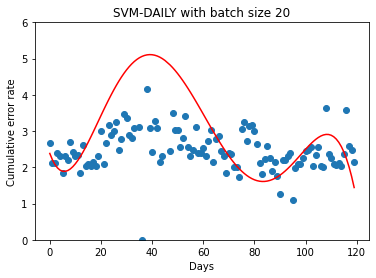

In [14]:
plot5degree(error_rates, batch_size, True)